In [1]:
%reset -sf
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from opt_einsum import contract
def _toN(t):
    return t.detach().cpu().numpy()
def printDiff(name,value,ref):
    if ref is not None:
        print(name+':',value,'diff(abs):',value-ref)
    else:
        print(name+':',value)

# SRG BaseClass

In [2]:
class SRG(torch.nn.Module):
    def __init__(self,params,options):
        super(SRG,self).__init__()
        self.dtype=options.get('dtype',torch.float64)
        self.device=options.get('device','cpu')
        self.max_dim=options.get('max_dim',16)
        self.nLayers=options.get('nLayers',10)
        self.use_checkpoint=options.get('use_checkpoint',True)
        
        
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        self.current_logZ=0
        
    def __str__(self):
        rtval=""
        for k,v in self.params.items():
            rtval+=k+':'+v+'\n'
        rtval+='dtype:'+self.dtype+'\n'
        rtval+='device:'+self.device+'\n'
        rtval+='max_dim:'+self.max_dim+'\n'
        rtval+='nLayers:'+self.nLayers+'\n'
        rtval+='nSite:'+2**nLayers+'\n'
        
    def generate_random_Isometry(self,dim1,dim2):
        dim=max(dim1,dim2)
        A=torch.randn(dim,dim,dtype=self.dtype,device=self.device)
        U=torch.matrix_exp(A-A.t())
        U=U[:dim1,:dim2]
        return U
    
    def TRG_same_T(self,T,*w):
        return self.TRG(T,T,*w)
    
    def forward_tensor(self):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
            else:
                T=self.TRG_same_T(T,*w)
                
            norm=torch.linalg.norm(T)
            T=T/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,logTotal
    
    def forward_tensor_with_observable(self,T_op):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T1=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
                T2=torch.utils.checkpoint.checkpoint(self.TRG,T,T_op,*w)
                T3=torch.utils.checkpoint.checkpoint(self.TRG,T_op,T,*w)
            else:
                T1=self.TRG_same_T(T,*w)
                T2=self.TRG(T,T_op,*w)
                T3=self.TRG(T_op,T,*w)
                
            T,T_op=T1,(T2+T3)/2
            norm=torch.linalg.norm(T)
            T,T_op=T/norm,T_op/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,T_op,logTotal
    
    
    def dlogZ(self,param):
        self.requires_grad_(False)
        self.params[param].requires_grad_(True)
        self.zero_grad()
        logZ=self.forward()
        logZ.backward()
        result=_toN(self.params[param].grad)
        self.params[param].requires_grad_(False)
        return result
    
    def update_single_layer(self,layer):
        self.requires_grad_(False)
        
        for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
            self.ws[i].requires_grad_(True)
        self.zero_grad()
        
        logZ=self.forward()
        logZ.backward()
        
        with torch.no_grad():
            for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
                E=self.ws[i].grad
                dim1,dim2=E.shape[0],E.shape[2]
                E=E.reshape(dim1*dim1,dim2)
                U,S,Vh=torch.linalg.svd(E,full_matrices=False)
                UVh=U@Vh
                del U,S,Vh
                #UVh=svd2UVh(E)
                self.ws[i].data=UVh.reshape(dim1,dim1,dim2)
                del E,UVh
                
        torch.cuda.empty_cache()
        self.current_logZ=_toN(logZ)
        
    def optimize(self,nIter,ref_logZ=None):
        torch.cuda.empty_cache()
        if nIter>1:
            pbar2=tqdm(range(nIter), leave=False)
            pbar2.set_postfix({k:_toN(v) for k,v in self.params.items()})
        else:
            pbar2=range(nIter)
        for i in pbar2:
            pbar=tqdm(range(self.nLayers-1,-1,-1), leave=False)
            for j in pbar:
                self.update_single_layer(j)
                if ref_logZ is not None:
                    pbar.set_postfix({"diff":self.current_logZ-ref_logZ})
                else:
                    pbar.set_postfix({"logZ":self.current_logZ})
                torch.cuda.empty_cache()
        #printDiff('logZ',toN(forward(params,ws)),ref_logZ)
        torch.cuda.empty_cache()
        #lock all grads
        for param in self.params.values(): 
            param.requires_grad_(False)
        for i in range(self.nLayers): #slightly faster
            self.ws[i].requires_grad_(False)

In [3]:
class HOTRG(SRG):
    def __init__(self,params,options):
        super(HOTRG,self).__init__(params,options)
    
    def create_params(self,start_dim,spacial_dim):
        ws=[]
        bond_dim=[start_dim]*spacial_dim
        for i in range(self.nLayers):
            for j in range(1,spacial_dim):
                old_dim=bond_dim[j]
                new_dim=min(old_dim**2,self.max_dim)
                U=self.generate_random_Isometry(old_dim**2,new_dim).view(old_dim,old_dim,new_dim)
                ws.append(U.detach())
                bond_dim[j]=new_dim
            bond_dim=bond_dim[1:]+[bond_dim[0]]
        self.ws=torch.nn.ParameterList([
            torch.nn.Parameter(v) for v in ws
        ])
        self.w_per_layer=spacial_dim-1
        
    def HOTRG2D(self,T1,T2,w):
        return contract('ijkl,jmno,kna,lob->abim',T1,T2,w,w)#contract and rotate
    
    def HOTRG3D(self,T1,T2,w1,w2):
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio',T1,T2,w1,w1,w2,w2)#contract and rotate
    
    def forward(self):
        T,logTotal=self.forward_tensor()
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        return (torch.log(Z)+logTotal)/2**self.nLayers
    
    def forward_with_observable(self,T_op):
        T,T_op,_=self.forward_tensor_with_observable(T_op)
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        Z_op=contract(T_op,contract_all)
        return Z_op/Z

# Ising2D

In [4]:
class Ising2D(HOTRG):
    def __init__(self,params,options):
        super(Ising2D,self).__init__(params,options)
        self.create_params(start_dim=2,spacial_dim=2)
        self.TRG=self.HOTRG2D
        
    def get_T0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,a->ijkl',W,W,W,W,sz)#UDLR
    
    def get_SZT0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),-torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,a->ijkl',W,W,W,W,sz)#UDLR
    
    def get_magnetization(self):
        with torch.no_grad():
            return _toN(torch.abs(self.forward_with_observable(self.get_SZT0())))



# Ising2D Test

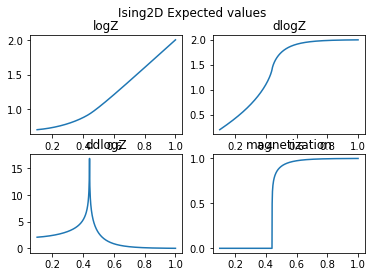

critical_beta 0.4406867935097715
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 24, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.44, 'h': 0}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/wenhan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

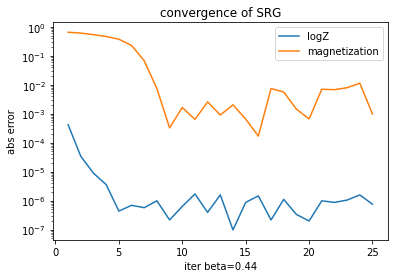

In [5]:
#test
from IsingSolutions import Ising2DExactSolution
ising2d=Ising2DExactSolution()
ising2d.display()

options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':24,
    'nLayers':30,
    'use_checkpoint':True
}
beta=0.44
params={'beta':beta,'h':0}
srg=Ising2D(params,options)
print(options)
print(params)

data=pd.DataFrame(columns=['beta','iter','logZ','magnetization'])
for i in tqdm(range(25)):
    srg.optimize(1,ref_logZ=ising2d.logZ(beta))
    num_iter=i+1
    data=data.append({'beta':beta,'iter':num_iter,'logZ':srg.current_logZ,'magnetization':srg.get_magnetization()},ignore_index=True)

plt.plot(data['iter'],np.abs(data['logZ']-ising2d.logZ(beta)))
plt.plot(data['iter'],np.abs(data['magnetization']-ising2d.magnetization(beta)))
plt.yscale('log')
plt.xlabel(f'iter beta={beta}')
plt.ylabel('abs error')
plt.legend(['logZ','magnetization'])
plt.title('convergence of SRG')
plt.show()


# XTRG

In [3]:
class XTRG(SRG):
    def __init__(self,params,options):
        super(XTRG,self).__init__(params,options)
        
    def create_params(self,start_dim,spacial_dim):
        ws=[]
        bond_dim=start_dim
        for i in range(self.nLayers):
            old_dim=bond_dim
            new_dim=min(old_dim**2,self.max_dim)
            for j in range(1,spacial_dim):
                U=self.generate_random_Isometry(old_dim**2,new_dim).view(old_dim,old_dim,new_dim)
                ws.append(U.detach())
            bond_dim=new_dim
        self.ws=torch.nn.ParameterList([
            torch.nn.Parameter(v) for v in ws
        ])
        self.w_per_layer=spacial_dim-1

    def XTRG2D(self,T1,T2,w):
        return contract('ijkl,jmno,kna,lob->imab',T1,T2,w,w)#contract only
    
    def XTRG3D(self,T1,T2,w1,w2):
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->ioabc',T1,T2,w1,w1,w2,w2)#contract only
    
    def forward(self):
        #return self.forward_final_2D()
        
        T,logTotal=self.forward_tensor()
        return logTotal/2**self.nLayers
    
    def forward_matrix_powers_trace_normalized(self,M):
        R=M
        for i in range(400):
            R=R@R
            R=R/torch.trace(R)
        return R
    
    def forward_final_2D(self):
        T,logTotal=self.forward_tensor()
        M=contract('iikl->kl',T)
        R=self.forward_matrix_powers_trace_normalized(M)
        n=torch.norm(M@R)
        #print(n)
        return (torch.log(n)+logTotal)/2**self.nLayers
    
    def forward_with_observable_2D(self,T_op):
        T,T_op,_=self.forward_tensor_with_observable(T_op)
        M=contract('iikl->kl',T)
        R=self.forward_matrix_powers_trace_normalized(M)
        M_op=contract('iikl->kl',T_op)
        return torch.trace(M_op@R)/torch.trace(M@R)

In [4]:
class Ising2DXTRG(XTRG):
    def __init__(self,params,options):
        super(Ising2DXTRG,self).__init__(params,options)
        self.create_params(start_dim=2,spacial_dim=2)
        self.TRG=self.XTRG2D
        
    def get_T0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,a->ijkl',W,W,W,W,sz)#UDLR
    
    def get_SZT0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),-torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,a->ijkl',W,W,W,W,sz)#UDLR
    
    def get_magnetization(self):
        with torch.no_grad():
            return _toN(torch.abs(self.forward_with_observable_2D(self.get_SZT0())))

    def get_logZ(self):
        with torch.no_grad():
            return _toN(self.forward_final_2D())



# Ising2DXTRG Test

In [5]:


options={
    'dtype':torch.float64,
    'device':'cuda:0',
    'max_dim':48,
    'nLayers':30,
    'use_checkpoint':True
}
beta=0.44
params={'beta':beta,'h':0}
srg=Ising2DXTRG(params,options)
print(options)
print(params)

data=pd.DataFrame(columns=['beta','iter','logZ','magnetization'])
for i in tqdm(range(2500)):
    srg.optimize(1,ref_logZ=ising2d.logZ(beta))
    num_iter=i+1
    data=data.append({'beta':beta,'iter':num_iter, 'logZ':srg.get_logZ(),'magnetization':srg.get_magnetization()},ignore_index=True)
    #print(data[-1:])
    data.to_csv('test_data.csv')


{'dtype': torch.float64, 'device': 'cuda:0', 'max_dim': 48, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.44, 'h': 0}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

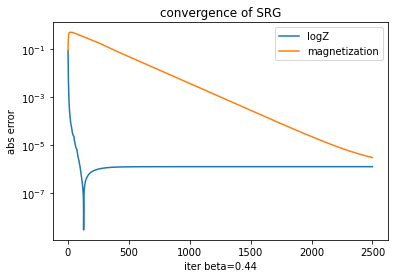

{'beta': 0.44, 'h': 0}
{'dtype': torch.float64, 'device': 'cuda:0', 'max_dim': 48, 'nLayers': 30, 'use_checkpoint': True}


In [6]:
from IsingSolutions import Ising2DExactSolution
ising2d=Ising2DExactSolution()
#ising2d.display()
#print(ising2d.critical_beta)

data=pd.read_csv('test_data.csv')
plt.plot(data['iter'],np.abs(data['logZ']-ising2d.logZ(beta)))
plt.plot(data['iter'],np.abs(data['magnetization']-ising2d.magnetization(beta)))
plt.yscale('log')
plt.xlabel(f'iter beta={beta}')
plt.ylabel('abs error')
plt.legend(['logZ','magnetization'])
plt.title('convergence of SRG')
plt.show()
print(params)
print(options)


# Expected magnetization curve

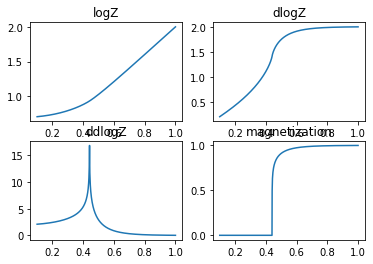

0.4406867935097715


In [7]:
from IsingSolutions import Ising2DExactSolution
ising2d=Ising2DExactSolution()
ising2d.display()
print(ising2d.critical_beta)

# Try to reimplement the nonconvergence plot

In [5]:
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':6,
    'nLayers':30,
    'use_checkpoint':True
}
data=pd.DataFrame(columns=['beta','iter','logZ','magnetization'])

for beta in np.linspace(0.4,0.45,15):
    params={'beta':beta,'h':0}
    srg=Ising2D(params,options)
    print('='*20)
    print(options)
    print(params)
    for i in range(25):
        srg.optimize(1)
        num_iter=i+1
        m=srg.get_magnetization()
        logZ=srg.get_logZ()
        print('iter',num_iter)
        printDiff('logZ',logZ,ising2d.logZ(beta))
        printDiff('magnetization',m,ising2d.magnetization(beta))
        data=data.append({'beta':beta,'iter':num_iter,'logZ':logZ,'magnetization':m},ignore_index=True)
print(data)

{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.4, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


iter 1
logZ 0.872795
magnetization: 0.60398316 diff(abs): 0.6039831638336182


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.87772113
magnetization: 0.32564506 diff(abs): 0.3256450593471527


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.8792268
magnetization: 0.07813506 diff(abs): 0.07813505828380585


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.8793576
magnetization: 0.0067374622 diff(abs): 0.006737462244927883


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.87936133
magnetization: 0.00026521255 diff(abs): 0.0002652125549502671


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.87936187
magnetization: 7.7206886e-07 diff(abs): 7.720688586232427e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.8793615
magnetization: 2.2818294e-05 diff(abs): 2.281829438288696e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.8793617
magnetization: 2.3099274e-05 diff(abs): 2.309927367605269e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.879362
magnetization: 1.7859687e-05 diff(abs): 1.7859687432064675e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.8793609
magnetization: 9.569513e-06 diff(abs): 9.56951316766208e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.879362
magnetization: 4.3083296e-06 diff(abs): 4.308329607738415e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.87936234
magnetization: 7.170497e-06 diff(abs): 7.170497156039346e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.87936133
magnetization: 1.033513e-05 diff(abs): 1.033513035508804e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.87936175
magnetization: 2.6414555e-06 diff(abs): 2.641455466800835e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.8793614
magnetization: 2.0442237e-06 diff(abs): 2.044223720076843e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.879362
magnetization: 4.2911314e-08 diff(abs): 4.291131361355838e-08


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.87936187
magnetization: 2.9408002e-06 diff(abs): 2.940800186479464e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.8793617
magnetization: 3.008928e-06 diff(abs): 3.0089279334788444e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.87936145
magnetization: 5.220809e-07 diff(abs): 5.220808816375211e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.879362
magnetization: 3.603596e-06 diff(abs): 3.6035960420122137e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.8793618
magnetization: 2.3915998e-06 diff(abs): 2.3915997644508025e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.8793623
magnetization: 2.253397e-06 diff(abs): 2.2533970422955463e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.8793617
magnetization: 8.9935764e-07 diff(abs): 8.993576443572238e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.8793617
magnetization: 2.2565935e-06 diff(abs): 2.2565934614249272e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.87936205
magnetization: 4.0719556e-06 diff(abs): 4.071955572726438e-06
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.4035714285714286, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.88030463
magnetization: 0.42012328 diff(abs): 0.42012327909469604


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.8829061
magnetization: 0.1614936 diff(abs): 0.16149359941482544


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.8833339
magnetization: 0.021745939 diff(abs): 0.021745938807725906


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.88334614
magnetization: 0.0013777995 diff(abs): 0.0013777995482087135


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.88334656
magnetization: 2.929993e-05 diff(abs): 2.9299930247361772e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.88334733
magnetization: 4.1175444e-06 diff(abs): 4.117544449400157e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.8833464
magnetization: 3.3595443e-06 diff(abs): 3.359544280101545e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.88334745
magnetization: 8.230502e-06 diff(abs): 8.230502317019273e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.883346
magnetization: 7.926837e-06 diff(abs): 7.92683658801252e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.8833466
magnetization: 5.7440916e-06 diff(abs): 5.744091595261125e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.88334614
magnetization: 2.5508726e-07 diff(abs): 2.5508725798317755e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.8833462
magnetization: 1.953156e-06 diff(abs): 1.95315601558832e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.8833467
magnetization: 5.9241033e-06 diff(abs): 5.924103334109532e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.8833465
magnetization: 2.8302454e-06 diff(abs): 2.8302454211370787e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.88334686
magnetization: 6.9258676e-06 diff(abs): 6.925867637619376e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.8833468
magnetization: 5.693623e-06 diff(abs): 5.693622824765043e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.8833464
magnetization: 1.3919322e-06 diff(abs): 1.3919321872890578e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.8833469
magnetization: 9.650695e-07 diff(abs): 9.650694892116007e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.88334686
magnetization: 1.0093823e-06 diff(abs): 1.0093823448187322e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.8833463
magnetization: 5.748476e-07 diff(abs): 5.748476041844697e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.88334703
magnetization: 1.0418904e-06 diff(abs): 1.041890413944202e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.88334686
magnetization: 1.06359275e-05 diff(abs): 1.06359275378054e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.883346
magnetization: 1.1470285e-05 diff(abs): 1.147028524428606e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.88334656
magnetization: 2.7440678e-06 diff(abs): 2.744067842286313e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.88334626
magnetization: 1.0670722e-06 diff(abs): 1.0670721621863777e-06
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.40714285714285714, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.8790591
magnetization: 0.5948544 diff(abs): 0.5948544144630432


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.88617253
magnetization: 0.28823662 diff(abs): 0.2882366180419922


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.8872976
magnetization: 0.07229308 diff(abs): 0.07229308038949966


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.8873992
magnetization: 0.005996028 diff(abs): 0.005996027961373329


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.8874016
magnetization: 0.00046355507 diff(abs): 0.0004635550722014159


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.8874021
magnetization: 7.642372e-05 diff(abs): 7.642371929250658e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.8874021
magnetization: 3.4926576e-05 diff(abs): 3.49265756085515e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.8874022
magnetization: 2.2109705e-05 diff(abs): 2.210970524174627e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.8874019
magnetization: 1.1269988e-05 diff(abs): 1.126998813560931e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.88740104
magnetization: 8.540763e-06 diff(abs): 8.54076279210858e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.8874017
magnetization: 5.686433e-06 diff(abs): 5.6864328144001774e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.8874017
magnetization: 8.814448e-06 diff(abs): 8.81444793776609e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.88740176
magnetization: 1.13628685e-05 diff(abs): 1.1362868463038467e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.8874019
magnetization: 6.3843e-06 diff(abs): 6.384299922501668e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.8874019
magnetization: 1.8453627e-06 diff(abs): 1.8453627035341924e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.88740224
magnetization: 7.681768e-10 diff(abs): 7.68176799947895e-10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.8874027
magnetization: 4.729996e-07 diff(abs): 4.72999602152413e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.8874012
magnetization: 2.5978675e-06 diff(abs): 2.5978674784710165e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.8874015
magnetization: 1.1673562e-06 diff(abs): 1.167356231235317e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.8874018
magnetization: 6.738643e-07 diff(abs): 6.738642923664884e-07


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.8874018
magnetization: 5.59738e-06 diff(abs): 5.597380095423432e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.8874014
magnetization: 2.507588e-06 diff(abs): 2.507588078515255e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.8874013
magnetization: 3.0068923e-06 diff(abs): 3.006892256962601e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.88740313
magnetization: 3.4336692e-06 diff(abs): 3.433669235164416e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.8874022
magnetization: 9.605775e-07 diff(abs): 9.605774948795442e-07
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.41071428571428575, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.8866032
magnetization: 0.49564713 diff(abs): 0.495647132396698


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.89053845
magnetization: 0.3014009 diff(abs): 0.30140089988708496


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.891465
magnetization: 0.06400189 diff(abs): 0.0640018880367279


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.8915288
magnetization: 0.006485868 diff(abs): 0.006485867779701948


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.8915303
magnetization: 0.00066706596 diff(abs): 0.0006670659640803933


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.89153004
magnetization: 0.0001567383 diff(abs): 0.00015673830057494342


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.89153117
magnetization: 8.725965e-05 diff(abs): 8.725965017220005e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.8915303
magnetization: 7.070904e-05 diff(abs): 7.070903666317463e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.89153045
magnetization: 5.0718503e-05 diff(abs): 5.071850318927318e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.89153105
magnetization: 2.6097188e-05 diff(abs): 2.609718831081409e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.89153063
magnetization: 4.9939053e-06 diff(abs): 4.9939053496927954e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.8915306
magnetization: 1.593593e-05 diff(abs): 1.5935929695842788e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.8915308
magnetization: 1.1575904e-05 diff(abs): 1.1575903954508249e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.8915301
magnetization: 1.1017135e-05 diff(abs): 1.101713496609591e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.89153093
magnetization: 9.626318e-06 diff(abs): 9.626318387745414e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.891531
magnetization: 2.6461812e-06 diff(abs): 2.646181201271247e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.8915305
magnetization: 1.4808807e-06 diff(abs): 1.4808806554356124e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.89153063
magnetization: 1.2161164e-06 diff(abs): 1.2161164022472803e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.8915309
magnetization: 5.461678e-06 diff(abs): 5.4616780289507005e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.89153063
magnetization: 1.901655e-05 diff(abs): 1.901655014080461e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.8915306
magnetization: 6.288603e-06 diff(abs): 6.288602889981121e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.89153135
magnetization: 7.840426e-06 diff(abs): 7.840426405891776e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.8915304
magnetization: 1.3454656e-05 diff(abs): 1.3454656254907604e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.8915308
magnetization: 1.4797178e-05 diff(abs): 1.4797177755099256e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.8915305
magnetization: 1.05223535e-05 diff(abs): 1.0522353477426805e-05
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.4142857142857143, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.8651246
magnetization: 0.7168045 diff(abs): 0.7168045043945312


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.8924544
magnetization: 0.60969484 diff(abs): 0.6096948385238647


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.8946317
magnetization: 0.38769126 diff(abs): 0.3876912593841553


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.8955983
magnetization: 0.11674846 diff(abs): 0.11674845963716507


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.8957332
magnetization: 0.0140502 diff(abs): 0.014050199650228024


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.8957359
magnetization: 0.0015760021 diff(abs): 0.001576002105139196


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.89573604
magnetization: 0.0003828332 diff(abs): 0.0003828332119155675


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.89573693
magnetization: 0.00024400176 diff(abs): 0.0002440017560729757


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.89573646
magnetization: 0.00020353145 diff(abs): 0.0002035314537351951


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.8957363
magnetization: 0.00017297198 diff(abs): 0.00017297198064625263


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.8957367
magnetization: 0.00013746144 diff(abs): 0.00013746143667958677


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.89573604
magnetization: 0.000120080804 diff(abs): 0.00012008080375380814


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.89573735
magnetization: 0.00010721061 diff(abs): 0.00010721060971263796


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.8957362
magnetization: 8.774926e-05 diff(abs): 8.774925663601607e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.8957369
magnetization: 7.499117e-05 diff(abs): 7.499117054976523e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.8957368
magnetization: 5.7696438e-05 diff(abs): 5.769643757957965e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.8957368
magnetization: 4.1928637e-05 diff(abs): 4.192863707430661e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.8957363
magnetization: 4.0365532e-05 diff(abs): 4.036553218611516e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.8957365
magnetization: 5.347501e-05 diff(abs): 5.347501064534299e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.895736
magnetization: 3.7917776e-05 diff(abs): 3.7917776353424415e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.8957367
magnetization: 3.5368546e-05 diff(abs): 3.536854637786746e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.89573693
magnetization: 2.7798524e-05 diff(abs): 2.7798523660749197e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.89573663
magnetization: 1.8272334e-05 diff(abs): 1.827233427320607e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.8957366
magnetization: 2.7766073e-05 diff(abs): 2.776607288978994e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.8957361
magnetization: 2.9120514e-05 diff(abs): 2.9120514227543026e-05
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.41785714285714287, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.8950458
magnetization: 0.46830952 diff(abs): 0.46830952167510986


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.89926463
magnetization: 0.33250526 diff(abs): 0.3325052559375763


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.899922
magnetization: 0.11268402 diff(abs): 0.11268401890993118


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.9000167
magnetization: 0.01816877 diff(abs): 0.018168769776821136


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.90002006
magnetization: 0.0021772224 diff(abs): 0.0021772223990410566


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9000209
magnetization: 0.0006519923 diff(abs): 0.0006519922753795981


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9000208
magnetization: 0.0005524231 diff(abs): 0.0005524231237359345


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.9000211
magnetization: 0.0005481084 diff(abs): 0.0005481084226630628


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.90002143
magnetization: 0.00055260735 diff(abs): 0.0005526073509827256


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.90002066
magnetization: 0.00054168026 diff(abs): 0.000541680259630084


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9000205
magnetization: 0.0005335585 diff(abs): 0.000533558486495167


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.900021
magnetization: 0.0005172878 diff(abs): 0.0005172878154553473


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.90002096
magnetization: 0.0005018807 diff(abs): 0.0005018807132728398


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.90002126
magnetization: 0.00048852054 diff(abs): 0.0004885205416940153


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9000202
magnetization: 0.00048559133 diff(abs): 0.0004855913284700364


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9000205
magnetization: 0.0004806742 diff(abs): 0.00048067420721054077


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.90002084
magnetization: 0.00047142498 diff(abs): 0.00047142498078756034


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.9000212
magnetization: 0.0004579036 diff(abs): 0.000457903603091836


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.9000209
magnetization: 0.00045480186 diff(abs): 0.0004548018623609096


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.90002096
magnetization: 0.00045597664 diff(abs): 0.00045597663847729564


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.900021
magnetization: 0.00045336602 diff(abs): 0.0004533660248853266


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.9000207
magnetization: 0.00045077511 diff(abs): 0.0004507751145865768


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.9000207
magnetization: 0.00043506082 diff(abs): 0.0004350608214735985


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.90002096
magnetization: 0.0004318417 diff(abs): 0.0004318417049944401


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.900021
magnetization: 0.00043484286 diff(abs): 0.000434842862887308
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.42142857142857143, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.8992317
magnetization: 0.5483565 diff(abs): 0.5483564734458923


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.9034887
magnetization: 0.454782 diff(abs): 0.45478200912475586


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.9042107
magnetization: 0.21202378 diff(abs): 0.2120237797498703


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.90437746
magnetization: 0.04690431 diff(abs): 0.0469043105840683


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.90439
magnetization: 0.006692701 diff(abs): 0.006692701019346714


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9043907
magnetization: 0.0015906479 diff(abs): 0.0015906478511169553


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9043907
magnetization: 0.00097468926 diff(abs): 0.0009746892610564828


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.90439063
magnetization: 0.00088173454 diff(abs): 0.000881734536960721


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.90439063
magnetization: 0.000843769 diff(abs): 0.0008437689975835383


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.9043909
magnetization: 0.00078327383 diff(abs): 0.0007832738338038325


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9043909
magnetization: 0.000771461 diff(abs): 0.0007714609964750707


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.90439075
magnetization: 0.0007729712 diff(abs): 0.0007729711942374706


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.90439045
magnetization: 0.00075045135 diff(abs): 0.000750451348721981


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.9043903
magnetization: 0.00074093614 diff(abs): 0.0007409361423924565


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9043901
magnetization: 0.0007230162 diff(abs): 0.0007230162154883146


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9043911
magnetization: 0.0007055138 diff(abs): 0.000705513812135905


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.90439034
magnetization: 0.00071115606 diff(abs): 0.0007111560553312302


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.9043898
magnetization: 0.00068647997 diff(abs): 0.0006864799652248621


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.9043902
magnetization: 0.00066251936 diff(abs): 0.0006625193636864424


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.90439016
magnetization: 0.0006378781 diff(abs): 0.0006378780817613006


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9043901
magnetization: 0.0006380767 diff(abs): 0.0006380766863003373


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.9043901
magnetization: 0.00064682506 diff(abs): 0.0006468250649049878


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.90439045
magnetization: 0.0006256458 diff(abs): 0.0006256458000279963


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.9043902
magnetization: 0.0006038624 diff(abs): 0.0006038623978383839


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.9043904
magnetization: 0.0006118797 diff(abs): 0.0006118796882219613
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.42500000000000004, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ nan
magnetization: 0.6951707 diff(abs): 0.6951707005500793


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.9074869
magnetization: 0.594956 diff(abs): 0.5949559807777405


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.9084499
magnetization: 0.38399833 diff(abs): 0.3839983344078064


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.90878683
magnetization: 0.14049317 diff(abs): 0.14049316942691803


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.90884435
magnetization: 0.02502287 diff(abs): 0.025022869929671288


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.90884775
magnetization: 0.0050405753 diff(abs): 0.005040575284510851


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9088474
magnetization: 0.0018730027 diff(abs): 0.0018730027368292212


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.90884745
magnetization: 0.0012240813 diff(abs): 0.001224081264808774


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.9088479
magnetization: 0.0010091268 diff(abs): 0.0010091267758980393


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.9088481
magnetization: 0.00088126876 diff(abs): 0.0008812687592580914


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9088472
magnetization: 0.00072973757 diff(abs): 0.0007297375705093145


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9088468
magnetization: 0.00061283115 diff(abs): 0.0006128311506472528


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.90884805
magnetization: 0.0005176785 diff(abs): 0.0005176785052753985


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.908847
magnetization: 0.00047242083 diff(abs): 0.0004724208265542984


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.90884715
magnetization: 0.00041197997 diff(abs): 0.0004119799705222249


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.90884715
magnetization: 0.00035862144 diff(abs): 0.0003586214443203062


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.90884775
magnetization: 0.000318088 diff(abs): 0.0003180879866704345


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.9088479
magnetization: 0.00027079822 diff(abs): 0.0002707982202991843


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.9088473
magnetization: 0.00022540745 diff(abs): 0.0002254074497614056


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.908848
magnetization: 0.00020704794 diff(abs): 0.00020704793860204518


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9088479
magnetization: 0.00017178277 diff(abs): 0.00017178276902996004


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.90884817
magnetization: 0.00013972168 diff(abs): 0.0001397216838086024


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.90884745
magnetization: 0.00011949775 diff(abs): 0.00011949775216635317


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.9088472
magnetization: 0.000117888034 diff(abs): 0.00011788803385570645


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.9088475
magnetization: 0.00010598796 diff(abs): 0.00010598795779515058
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.4285714285714286, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.9112319
magnetization: 0.71128094 diff(abs): 0.7112809419631958


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.91251284
magnetization: 0.60806656 diff(abs): 0.6080665588378906


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.91309255
magnetization: 0.42969167 diff(abs): 0.4296916723251343


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.9133284
magnetization: 0.21223563 diff(abs): 0.21223562955856323


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.91339093
magnetization: 0.06110495 diff(abs): 0.061104949563741684


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9133981
magnetization: 0.014451796 diff(abs): 0.014451796188950539


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9133986
magnetization: 0.0048597916 diff(abs): 0.004859791602939367


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.9133983
magnetization: 0.0025087395 diff(abs): 0.002508739475160837


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.91339886
magnetization: 0.0018890342 diff(abs): 0.0018890341743826866


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.9133988
magnetization: 0.0015810026 diff(abs): 0.00158100260887295


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9133987
magnetization: 0.00133672 diff(abs): 0.0013367199571803212


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9133981
magnetization: 0.0011706419 diff(abs): 0.001170641859062016


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.9133989
magnetization: 0.0010388014 diff(abs): 0.0010388013906776905


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.91339844
magnetization: 0.0009198807 diff(abs): 0.0009198806947097182


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.91339856
magnetization: 0.00081029645 diff(abs): 0.0008102964493446052


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.913398
magnetization: 0.0007153204 diff(abs): 0.0007153204060159624


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.91339874
magnetization: 0.00062834495 diff(abs): 0.0006283449474722147


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.9133987
magnetization: 0.0005735272 diff(abs): 0.0005735271843150258


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.9133979
magnetization: 0.000491231 diff(abs): 0.0004912309814244509


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9133982
magnetization: 0.00045571182 diff(abs): 0.0004557118227239698


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.91339827
magnetization: 0.00040040587 diff(abs): 0.0004004058719146997


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.91339844
magnetization: 0.00033788578 diff(abs): 0.0003378857800271362


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.9133982
magnetization: 0.00033726715 diff(abs): 0.0003372671490069479


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.9133983
magnetization: 0.00033598318 diff(abs): 0.00033598317531868815


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.9133983
magnetization: 0.0002942877 diff(abs): 0.00029428768903017044
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.43214285714285716, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.91329765
magnetization: 0.39924458 diff(abs): 0.3992445766925812


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.9176643
magnetization: 0.37640107 diff(abs): 0.37640106678009033


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.91797984
magnetization: 0.24507247 diff(abs): 0.24507246911525726


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.918042
magnetization: 0.09282825 diff(abs): 0.09282825142145157


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.91804993
magnetization: 0.027252587 diff(abs): 0.02725258655846119


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9180502
magnetization: 0.010718053 diff(abs): 0.010718053206801414


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.91805077
magnetization: 0.006535304 diff(abs): 0.0065353037789464


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.91805
magnetization: 0.005349601 diff(abs): 0.005349601153284311


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.91805106
magnetization: 0.0049780975 diff(abs): 0.0049780975095927715


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.9180504
magnetization: 0.0048309686 diff(abs): 0.00483096856623888


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.918051
magnetization: 0.004828013 diff(abs): 0.004828013014048338


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9180508
magnetization: 0.0048482567 diff(abs): 0.004848256707191467


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.91805017
magnetization: 0.0048606517 diff(abs): 0.004860651679337025


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.91804993
magnetization: 0.0048512784 diff(abs): 0.004851278383284807


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9180506
magnetization: 0.0048418394 diff(abs): 0.004841839428991079


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.91805047
magnetization: 0.0048303357 diff(abs): 0.004830335732549429


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.9180507
magnetization: 0.004805485 diff(abs): 0.004805484786629677


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.91804993
magnetization: 0.004797272 diff(abs): 0.00479727191850543


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.9180501
magnetization: 0.0047981623 diff(abs): 0.004798162262886763


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.91805
magnetization: 0.004791324 diff(abs): 0.0047913240268826485


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9180494
magnetization: 0.004845411 diff(abs): 0.00484541105106473


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.91805065
magnetization: 0.004865071 diff(abs): 0.004865070804953575


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.91805047
magnetization: 0.0048673768 diff(abs): 0.004867376759648323


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.91805065
magnetization: 0.0048463675 diff(abs): 0.00484636751934886


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.9180499
magnetization: 0.0048108986 diff(abs): 0.004810898564755917
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.4357142857142857, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.9140353
magnetization: 0.76040363 diff(abs): 0.7604036331176758


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.922052
magnetization: 0.70691746 diff(abs): 0.7069174647331238


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.9225401
magnetization: 0.63457996 diff(abs): 0.6345799565315247


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.9226938
magnetization: 0.5439553 diff(abs): 0.5439553260803223


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.9227621
magnetization: 0.42784593 diff(abs): 0.42784592509269714


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.92279327
magnetization: 0.29796493 diff(abs): 0.2979649305343628


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.922808
magnetization: 0.17285863 diff(abs): 0.17285862565040588


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.9228128
magnetization: 0.09247642 diff(abs): 0.09247642010450363


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.9228141
magnetization: 0.0513985 diff(abs): 0.05139850080013275


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.92281455
magnetization: 0.0318394 diff(abs): 0.03183940052986145


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9228144
magnetization: 0.022373138 diff(abs): 0.0223731379956007


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9228145
magnetization: 0.01742568 diff(abs): 0.01742568053305149


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.9228143
magnetization: 0.0148808425 diff(abs): 0.01488084252923727


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.9228148
magnetization: 0.01339657 diff(abs): 0.013396570459008217


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9228145
magnetization: 0.012324436 diff(abs): 0.012324435636401176


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9228147
magnetization: 0.011588841 diff(abs): 0.011588840745389462


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.9228143
magnetization: 0.011058775 diff(abs): 0.011058774776756763


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.9228151
magnetization: 0.01051578 diff(abs): 0.010515780188143253


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.92281455
magnetization: 0.0100049 diff(abs): 0.010004900395870209


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9228148
magnetization: 0.009830965 diff(abs): 0.009830964729189873


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9228147
magnetization: 0.009640094 diff(abs): 0.009640093892812729


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.9228148
magnetization: 0.009332332 diff(abs): 0.009332331828773022


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.9228147
magnetization: 0.009296243 diff(abs): 0.009296243079006672


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.92281485
magnetization: 0.009361627 diff(abs): 0.009361626580357552


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.92281437
magnetization: 0.00940252 diff(abs): 0.009402520023286343
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.4392857142857143, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.92537546
magnetization: 0.7993194 diff(abs): 0.7993193864822388


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.9272935
magnetization: 0.719961 diff(abs): 0.7199609875679016


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.92759395
magnetization: 0.66073203 diff(abs): 0.6607320308685303


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.9276791
magnetization: 0.60356957 diff(abs): 0.6035695672035217


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.9276996
magnetization: 0.5579935 diff(abs): 0.557993471622467


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9277063
magnetization: 0.52176064 diff(abs): 0.5217606425285339


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.92770827
magnetization: 0.4922093 diff(abs): 0.4922092854976654


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.92770994
magnetization: 0.46982187 diff(abs): 0.46982187032699585


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.9277105
magnetization: 0.453776 diff(abs): 0.4537760019302368


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.9277101
magnetization: 0.44212794 diff(abs): 0.44212794303894043


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9277103
magnetization: 0.43395802 diff(abs): 0.4339580237865448


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.92771
magnetization: 0.4284933 diff(abs): 0.42849329113960266


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.92771024
magnetization: 0.42486164 diff(abs): 0.4248616397380829


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.9277094
magnetization: 0.42262322 diff(abs): 0.4226232171058655


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9277104
magnetization: 0.42124128 diff(abs): 0.42124128341674805


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9277106
magnetization: 0.42010817 diff(abs): 0.4201081693172455


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.9277104
magnetization: 0.4192917 diff(abs): 0.4192917048931122


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.92771065
magnetization: 0.41863465 diff(abs): 0.41863465309143066


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.92771107
magnetization: 0.4181834 diff(abs): 0.4181833863258362


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9277101
magnetization: 0.41785872 diff(abs): 0.41785871982574463


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.92771024
magnetization: 0.4179638 diff(abs): 0.41796380281448364


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.9277111
magnetization: 0.4183204 diff(abs): 0.4183203876018524


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.92771125
magnetization: 0.41815868 diff(abs): 0.4181586802005768


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.92771065
magnetization: 0.4178856 diff(abs): 0.41788560152053833


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.92770994
magnetization: 0.41789106 diff(abs): 0.4178910553455353
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.44285714285714284, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.9306351
magnetization: 0.82263744 diff(abs): 0.1957094571534087


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.93239963
magnetization: 0.75636244 diff(abs): 0.12943445658120412


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.93272483
magnetization: 0.7044141 diff(abs): 0.07748614763650197


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.9327873
magnetization: 0.6707124 diff(abs): 0.043784429782955825


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.93279386
magnetization: 0.6543728 diff(abs): 0.027444829696743667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9327967
magnetization: 0.64731747 diff(abs): 0.020389487499325454


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9327967
magnetization: 0.64449924 diff(abs): 0.017571260685055434


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.9327965
magnetization: 0.6433747 diff(abs): 0.01644669985207814


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.9327963
magnetization: 0.642946 diff(abs): 0.01601802324685353


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.9327958
magnetization: 0.6427831 diff(abs): 0.015855123752682387


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9327951
magnetization: 0.64270467 diff(abs): 0.015776684040157973


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9327956
magnetization: 0.6426747 diff(abs): 0.015746702903835952


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.9327965
magnetization: 0.64269423 diff(abs): 0.01576625322732228


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.9327964
magnetization: 0.6427081 diff(abs): 0.015780141109554946


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9327962
magnetization: 0.64268506 diff(abs): 0.01575707411202687


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.93279606
magnetization: 0.6426803 diff(abs): 0.01575230574044484


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.9327964
magnetization: 0.64269626 diff(abs): 0.015768279785244643


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.93279684
magnetization: 0.6427083 diff(abs): 0.015780319923489272


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.9327969
magnetization: 0.6426855 diff(abs): 0.015757491344540298


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9327964
magnetization: 0.64267933 diff(abs): 0.015751352066128432


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.93279606
magnetization: 0.64270246 diff(abs): 0.015774478668301284


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.932796
magnetization: 0.64270836 diff(abs): 0.015780379528134048


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.93279594
magnetization: 0.6427041 diff(abs): 0.015776147598354995


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.9327961
magnetization: 0.64271826 diff(abs): 0.015790273899166762


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.9327965
magnetization: 0.6427185 diff(abs): 0.015790512317745864
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.44642857142857145, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.937061
magnetization: 0.80837804 diff(abs): 0.10134408698314423


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.9378853
magnetization: 0.76261276 diff(abs): 0.055578806259572455


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.9380097
magnetization: 0.73475724 diff(abs): 0.02772329077953095


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.9380273
magnetization: 0.71937335 diff(abs): 0.012339391567647406


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.93802893
magnetization: 0.7134281 diff(abs): 0.0063941262745260685


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9380308
magnetization: 0.7113264 diff(abs): 0.004292466499745795


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9380313
magnetization: 0.71075654 diff(abs): 0.0037225864910482853


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.93803024
magnetization: 0.7105772 diff(abs): 0.003543236114919135


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.93802977
magnetization: 0.7104994 diff(abs): 0.00346545205348725


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.93802965
magnetization: 0.7104937 diff(abs): 0.0034597300075888127


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.93803155
magnetization: 0.71048313 diff(abs): 0.0034491799854635685


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9380307
magnetization: 0.7104803 diff(abs): 0.0034463189625143498


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.9380315
magnetization: 0.71047497 diff(abs): 0.00344101414912934


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.9380301
magnetization: 0.71046656 diff(abs): 0.00343260989421601


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9380298
magnetization: 0.710461 diff(abs): 0.0034270666622518986


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9380295
magnetization: 0.7104559 diff(abs): 0.003421940662801215


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.9380299
magnetization: 0.7104572 diff(abs): 0.0034232519649862736


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.93803054
magnetization: 0.7104564 diff(abs): 0.003422417499959418


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.93802917
magnetization: 0.71045595 diff(abs): 0.0034220002674459904


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9380299
magnetization: 0.71046114 diff(abs): 0.0034271858715414494


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9380304
magnetization: 0.71047086 diff(abs): 0.003436901428639838


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.9380312
magnetization: 0.7104624 diff(abs): 0.0034284375690817326


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.938029
magnetization: 0.7104499 diff(abs): 0.0034159205936789006


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.9380301
magnetization: 0.71044433 diff(abs): 0.0034103773617147892


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.93803054
magnetization: 0.7104474 diff(abs): 0.003413417198598334
{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.45, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 1
logZ 0.94141054
magnetization: 0.82341075 diff(abs): 0.07408813690304783


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.94317144
magnetization: 0.79127526 diff(abs): 0.04195265030026463


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.943362
magnetization: 0.76406914 diff(abs): 0.014746527425051004


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.94337994
magnetization: 0.7546949 diff(abs): 0.0053722665226462185


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.9433828
magnetization: 0.75144356 diff(abs): 0.0021209523594382107


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.943382
magnetization: 0.7506877 diff(abs): 0.0013651058590414822


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9433813
magnetization: 0.75053716 diff(abs): 0.0012145445263388455


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.94338185
magnetization: 0.7505055 diff(abs): 0.001182894459963113


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.9433816
magnetization: 0.7504894 diff(abs): 0.0011668012058737576


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.94338155
magnetization: 0.7504857 diff(abs): 0.0011631057178976834


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.9433821
magnetization: 0.75048614 diff(abs): 0.001163522950411111


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9433816
magnetization: 0.7504864 diff(abs): 0.0011637613689902127


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.94338274
magnetization: 0.75048816 diff(abs): 0.0011655495083334744


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.9433821
magnetization: 0.7504852 diff(abs): 0.0011625692760947048


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.943382
magnetization: 0.7504835 diff(abs): 0.001160900346040994


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9433827
magnetization: 0.7504822 diff(abs): 0.0011595890438559353


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.94338155
magnetization: 0.75048023 diff(abs): 0.0011576220905783474


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.94338214
magnetization: 0.75047964 diff(abs): 0.0011570260441305935


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.94338155
magnetization: 0.7504832 diff(abs): 0.001160602322817117


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9433824
magnetization: 0.75048524 diff(abs): 0.0011626288807394802


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9433821
magnetization: 0.75048816 diff(abs): 0.0011655495083334744


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.94338256
magnetization: 0.7504872 diff(abs): 0.0011645958340170681


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.94338256
magnetization: 0.7504841 diff(abs): 0.0011614963924887478


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.94338197
magnetization: 0.75048244 diff(abs): 0.0011598274624350369


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.94338185
magnetization: 0.75048214 diff(abs): 0.00115952943921116
     beta iter        logZ  magnetization
0    0.40    1    0.872795     0.60398316
1    0.40    2  0.87772113     0.32564506
2    0.40    3   0.8792268     0.07813506
3    0.40    4   0.8793576   0.0067374622
4    0.40    5  0.87936133  0.00026521255
..    ...  ...         ...            ...
370  0.45   21   0.9433821     0.75048816
371  0.45   22  0.94338256      0.7504872
372  0.45   23  0.94338256      0.7504841
373  0.45   24  0.94338197     0.75048244
374  0.45   25  0.94338185     0.75048214

[375 rows x 4 columns]


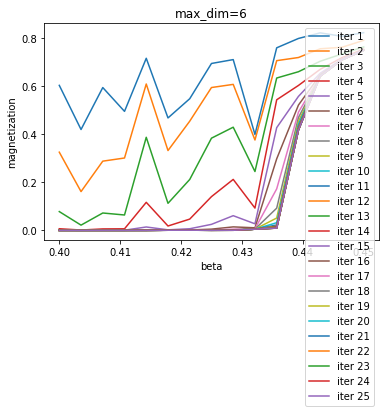

In [11]:
legends=[]
for i in range(25):
    mask=data['iter']==i+1
    plt.plot(data['beta'][mask],data['magnetization'][mask])
    legends.append(f'iter {i+1}')
plt.legend(legends)
plt.xlabel('beta')
plt.ylabel('magnetization')
plt.title(f'max_dim={6}')
plt.show()

# Try low bound dimension

In [8]:
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':6,
    'nLayers':30,
    'use_checkpoint':True
}
beta=0.44
params={'beta':beta,'h':0}
srg=Ising2D(params,options)
print(options)
print(params)
data=[]
for i in range(25):
    srg.optimize(1)
    num_iter=i+1
    m=srg.get_magnetization()
    logZ=srg.get_logZ()
    print('iter',num_iter)
    printDiff('logZ',logZ,ising2d.logZ(beta))
    printDiff('magnetization',m,ising2d.magnetization(beta))
    data.append([num_iter,logZ,m])
data=np.array(data).T


{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.44, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


iter 1
logZ 0.92627853
magnetization: 0.81989425 diff(abs): 0.8198942542076111


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.9281799
magnetization: 0.74736786 diff(abs): 0.7473678588867188


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.92859024
magnetization: 0.68295264 diff(abs): 0.6829526424407959


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.92867976
magnetization: 0.6315924 diff(abs): 0.6315923929214478


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.9287044
magnetization: 0.58858037 diff(abs): 0.5885803699493408


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.9287087
magnetization: 0.56002223 diff(abs): 0.560022234916687


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.9287107
magnetization: 0.54037803 diff(abs): 0.5403780341148376


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.9287123
magnetization: 0.52725387 diff(abs): 0.5272538661956787


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.92871314
magnetization: 0.5191055 diff(abs): 0.5191054940223694


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.92871225
magnetization: 0.514185 diff(abs): 0.5141850113868713


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.92871284
magnetization: 0.5113764 diff(abs): 0.5113763809204102


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.9287116
magnetization: 0.5096985 diff(abs): 0.5096985101699829


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.92871284
magnetization: 0.50890046 diff(abs): 0.5089004635810852


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.92871344
magnetization: 0.5084236 diff(abs): 0.5084236264228821


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.9287118
magnetization: 0.50796676 diff(abs): 0.5079667568206787


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.9287131
magnetization: 0.5078271 diff(abs): 0.50782710313797


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.92871284
magnetization: 0.50785106 diff(abs): 0.5078510642051697


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.9287131
magnetization: 0.5077751 diff(abs): 0.5077751278877258


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.92871225
magnetization: 0.50763977 diff(abs): 0.5076397657394409


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.9287131
magnetization: 0.507714 diff(abs): 0.5077139735221863


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.9287122
magnetization: 0.50785905 diff(abs): 0.5078590512275696


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.9287136
magnetization: 0.5079401 diff(abs): 0.5079401135444641


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.92871255
magnetization: 0.5079924 diff(abs): 0.5079923868179321


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.9287125
magnetization: 0.5078454 diff(abs): 0.507845401763916


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.92871267
magnetization: 0.5077434 diff(abs): 0.5077434182167053


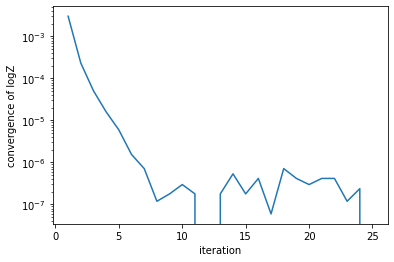

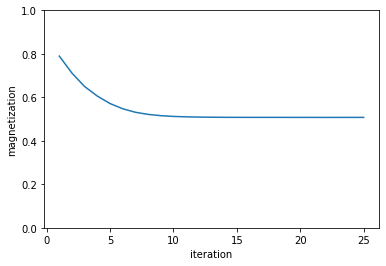

In [28]:
plt.plot(data[0],np.abs(data[1]-data[1,-1]))
plt.xlabel('iteration')
plt.ylabel('convergence of logZ')
plt.yscale('log')
plt.show()

plt.plot(data[0],np.abs(data[2]))
plt.xlabel('iteration')
plt.ylabel('magnetization')
plt.ylim([0,1])
plt.show()

# Ising 3D

In [3]:
class Ising3D(SRG):
    def __init__(self,params,options):
        super(Ising3D,self).__init__(params,options)
        self.create_params_HOTRG(start_dim=2,spacial_dim=3)
        self.TRG=self.HOTRG3D
        
    def get_T0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,am,an,a->ijklmn',W,W,W,W,W,W,sz)
    
    def get_SZT0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),-torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,am,an,a->ijklmn',W,W,W,W,W,W,sz)
    
    def get_magnetization(self):
        with torch.no_grad():
            return _toN(torch.abs(self.forward_with_observable(self.get_SZT0())))

# Expected magnetization curve

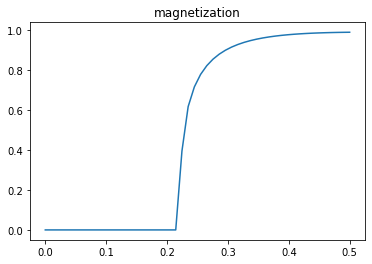

0.2216544


In [4]:
from IsingSolutions import Ising3DMonteCarlo
ising3d=Ising3DMonteCarlo()
ising3d.display()
print(ising3d.critical_beta)

# Try higher max_dim

In [ ]:
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':10,
    'nLayers':30,
    'use_checkpoint':True
}
data=pd.DataFrame(columns=['beta','iter','logZ','magnetization'])

In [8]:


for beta in [0.21,0.22]:
    params={'beta':beta,'h':0}
    srg=Ising3D(params,options)
    print('='*20)
    print(options)
    print(params)
    for i in range(25):
        srg.optimize(1)
        num_iter=i+1
        m=srg.get_magnetization()
        print('iter',num_iter)
        print('logZ',srg.)
        printDiff('magnetization',m,ising3d.magnetization(beta))
        data=data.append({'beta':beta,'iter':num_iter,'logZ':srg.,'magnetization':m},ignore_index=True)
    print(data)

{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 10, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.21, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


iter 1
logZ nan
magnetization: 0.60637516 diff(abs): 0.6063751578330994


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.763765
magnetization: 0.35532692 diff(abs): 0.35532692074775696


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.7663754
magnetization: 0.16005345 diff(abs): 0.16005344688892365


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.76691127
magnetization: 0.057289213 diff(abs): 0.05728921294212341


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.767006
magnetization: 0.017169343 diff(abs): 0.017169343307614326


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.7670217
magnetization: 0.004971067 diff(abs): 0.004971066955476999


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.76702696
magnetization: 0.0014991534 diff(abs): 0.0014991534408181906


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.7670278
magnetization: 0.0004594267 diff(abs): 0.0004594266938511282


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.7670309
magnetization: 0.00013988664 diff(abs): 0.00013988664431963116


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.76703054
magnetization: 4.0430066e-05 diff(abs): 4.043006629217416e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.76702994
magnetization: 2.9461241e-06 diff(abs): 2.9461241410899675e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.7670302
magnetization: 9.492164e-06 diff(abs): 9.4921642812551e-06


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.76702905
magnetization: 1.723976e-05 diff(abs): 1.7239759472431615e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.7670291
magnetization: 2.4253692e-05 diff(abs): 2.425369166303426e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.76703006
magnetization: 2.2400098e-05 diff(abs): 2.2400097805075347e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.7670297
magnetization: 1.9774245e-05 diff(abs): 1.9774244719883427e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.7670303
magnetization: 1.6462838e-05 diff(abs): 1.646283817535732e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.7670307
magnetization: 1.7532986e-05 diff(abs): 1.7532986021251418e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.7670303
magnetization: 2.0440242e-05 diff(abs): 2.0440242224140093e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.7670304
magnetization: 2.2413975e-05 diff(abs): 2.2413974875235e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.7670294
magnetization: 2.9605311e-05 diff(abs): 2.9605311283376068e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.76703113
magnetization: 2.8479923e-05 diff(abs): 2.8479922548285685e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.76703125
magnetization: 2.4626666e-05 diff(abs): 2.462666634528432e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.76703197
magnetization: 2.320789e-05 diff(abs): 2.320788917131722e-05


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.76703054
magnetization: 2.3403023e-05 diff(abs): 2.3403023078572005e-05
    beta iter        logZ  magnetization
0   0.21    1         nan     0.60637516
1   0.21    2    0.763765     0.35532692
2   0.21    3   0.7663754     0.16005345
3   0.21    4  0.76691127    0.057289213
4   0.21    5    0.767006    0.017169343
5   0.21    6   0.7670217    0.004971067
6   0.21    7  0.76702696   0.0014991534
7   0.21    8   0.7670278   0.0004594267
8   0.21    9   0.7670309  0.00013988664
9   0.21   10  0.76703054  4.0430066e-05
10  0.21   11  0.76702994  2.9461241e-06
11  0.21   12   0.7670302   9.492164e-06
12  0.21   13  0.76702905   1.723976e-05
13  0.21   14   0.7670291  2.4253692e-05
14  0.21   15  0.76703006  2.2400098e-05
15  0.21   16   0.7670297  1.9774245e-05
16  0.21   17   0.7670303  1.6462838e-05
17  0.21   18   0.7670307  1.7532986e-05
18  0.21   19   0.7670303  2.0440242e-05
19  0.21   20   0.7670304  2.2413975e-05
20  0.21   21   0.7670294  2.9605311e-05
21  0.21   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


iter 1
logZ 0.7655415
magnetization: 0.4927892 diff(abs): 0.49278920888900757


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.7747772
magnetization: 0.43704805 diff(abs): 0.4370480477809906


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.77544886
magnetization: 0.37204716 diff(abs): 0.37204715609550476


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.77564734
magnetization: 0.32115868 diff(abs): 0.32115867733955383


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.7757073
magnetization: 0.29120553 diff(abs): 0.2912055253982544


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.7757354
magnetization: 0.27153555 diff(abs): 0.2715355455875397


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.7757489
magnetization: 0.25795487 diff(abs): 0.257954865694046


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.7757534
magnetization: 0.24918562 diff(abs): 0.24918562173843384


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.77575386
magnetization: 0.24372558 diff(abs): 0.24372558295726776


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.7757548
magnetization: 0.24016382 diff(abs): 0.24016381800174713


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.7757544
magnetization: 0.23765588 diff(abs): 0.2376558780670166


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.7757562
magnetization: 0.23568891 diff(abs): 0.23568890988826752


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.77575666
magnetization: 0.2339961 diff(abs): 0.23399609327316284


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.77575815
magnetization: 0.2324906 diff(abs): 0.23249059915542603


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.7757582
magnetization: 0.23117061 diff(abs): 0.23117060959339142


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.7757597
magnetization: 0.23006436 diff(abs): 0.23006436228752136


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.7757589
magnetization: 0.22921863 diff(abs): 0.22921863198280334


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.7757594
magnetization: 0.22863209 diff(abs): 0.2286320924758911


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.77575916
magnetization: 0.22824517 diff(abs): 0.22824516892433167


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.77575976
magnetization: 0.22799191 diff(abs): 0.22799190878868103


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.7757594
magnetization: 0.22782862 diff(abs): 0.22782862186431885


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.7757604
magnetization: 0.22771746 diff(abs): 0.22771745920181274


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.775759
magnetization: 0.2276457 diff(abs): 0.22764569520950317


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.77575904
magnetization: 0.22759515 diff(abs): 0.22759515047073364


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.7757592
magnetization: 0.22755133 diff(abs): 0.22755132615566254
    beta iter        logZ  magnetization
0   0.21    1         nan     0.60637516
1   0.21    2    0.763765     0.35532692
2   0.21    3   0.7663754     0.16005345
3   0.21    4  0.76691127    0.057289213
4   0.21    5    0.767006    0.017169343
5   0.21    6   0.7670217    0.004971067
6   0.21    7  0.76702696   0.0014991534
7   0.21    8   0.7670278   0.0004594267
8   0.21    9   0.7670309  0.00013988664
9   0.21   10  0.76703054  4.0430066e-05
10  0.21   11  0.76702994  2.9461241e-06
11  0.21   12   0.7670302   9.492164e-06
12  0.21   13  0.76702905   1.723976e-05
13  0.21   14   0.7670291  2.4253692e-05
14  0.21   15  0.76703006  2.2400098e-05
15  0.21   16   0.7670297  1.9774245e-05
16  0.21   17   0.7670303  1.6462838e-05
17  0.21   18   0.7670307  1.7532986e-05
18  0.21   19   0.7670303  2.0440242e-05
19  0.21   20   0.7670304  2.2413975e-05
20  0.21   21   0.7670294  2.9605311e-05
21  0.21   22  0.7

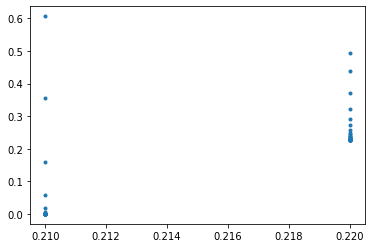

In [9]:
plt.plot(data['beta'],data['magnetization'],'.')
plt.show()

# Compare with Wei's code

In [ ]:
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':6,
    'nLayers':30,
    'use_checkpoint':True
}
beta=0.25
params={'beta':beta,'h':0}
srg=Ising3D(params,options)
print(options)
print(params)
data=[]
for i in range(100):
    srg.optimize(1)
    num_iter=i+1
    m=srg.get_magnetization()
    print('iter',num_iter)
    print('logZ',srg.)
    printDiff('magnetization',m,ising3d.magnetization(beta))
    data.append([num_iter,srg.,m])
data=np.array(data).T

{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 6, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.25, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


iter 1
logZ 0.8125253
magnetization: 0.74142605 diff(abs): -0.009477975917629777


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 2
logZ 0.82112586
magnetization: 0.7579734 diff(abs): 0.007069346355624617


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 3
logZ 0.8212239
magnetization: 0.7563113 diff(abs): 0.00540727083606285


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 4
logZ 0.82126516
magnetization: 0.7547992 diff(abs): 0.003895160602755965


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 5
logZ 0.82128066
magnetization: 0.75415385 diff(abs): 0.0032498211137728106


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 6
logZ 0.8212873
magnetization: 0.7538717 diff(abs): 0.0029676527254061114


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 7
logZ 0.8212894
magnetization: 0.7537613 diff(abs): 0.002857264923282088


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 8
logZ 0.82129073
magnetization: 0.75372124 diff(abs): 0.0028172106019930254


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 9
logZ 0.82129073
magnetization: 0.7537066 diff(abs): 0.0028025478593782793


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 10
logZ 0.821291
magnetization: 0.7536999 diff(abs): 0.0027958721391634356


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 11
logZ 0.8212906
magnetization: 0.7536953 diff(abs): 0.0027912825815157305


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 12
logZ 0.8212897
magnetization: 0.7536911 diff(abs): 0.0027870506517366778


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 13
logZ 0.82129055
magnetization: 0.7536882 diff(abs): 0.002784189628787459


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 14
logZ 0.82129085
magnetization: 0.7536862 diff(abs): 0.0027821630708650957


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 15
logZ 0.82129115
magnetization: 0.75368416 diff(abs): 0.0027801365129427325


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 16
logZ 0.82129115
magnetization: 0.75368166 diff(abs): 0.002777633117862166


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 17
logZ 0.821291
magnetization: 0.7536802 diff(abs): 0.0027762026063875567


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 18
logZ 0.82129127
magnetization: 0.7536786 diff(abs): 0.002774593280978621


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 19
logZ 0.82129157
magnetization: 0.75367737 diff(abs): 0.002773341583438338


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 20
logZ 0.8212913
magnetization: 0.7536765 diff(abs): 0.002772447513766707


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 21
logZ 0.8212915
magnetization: 0.75367534 diff(abs): 0.0027713150255159746


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 22
logZ 0.8212903
magnetization: 0.75367486 diff(abs): 0.0027708381883577715


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 23
logZ 0.8212912
magnetization: 0.7536736 diff(abs): 0.0027695864908174883


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 24
logZ 0.8212913
magnetization: 0.7536727 diff(abs): 0.0027686924211458575


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 25
logZ 0.8212912
magnetization: 0.7536724 diff(abs): 0.0027683943979219805


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 26
logZ 0.82129157
magnetization: 0.75367147 diff(abs): 0.0027674407236055742


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 27
logZ 0.8212912
magnetization: 0.753671 diff(abs): 0.002766963886447371


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 28
logZ 0.8212909
magnetization: 0.7536702 diff(abs): 0.002766189026065291


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 29
logZ 0.8212916
magnetization: 0.7536701 diff(abs): 0.0027660698167757403


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 30
logZ 0.82129174
magnetization: 0.75367004 diff(abs): 0.002766010212130965


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 31
logZ 0.8212908
magnetization: 0.7536695 diff(abs): 0.0027654737703279864


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 32
logZ 0.82129174
magnetization: 0.753669 diff(abs): 0.0027649969331697832


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 33
logZ 0.8212915
magnetization: 0.7536689 diff(abs): 0.0027648777238802325


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 34
logZ 0.82129127
magnetization: 0.75366926 diff(abs): 0.002765235351748885


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 35
logZ 0.82129145
magnetization: 0.7536692 diff(abs): 0.0027651757471041094


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 36
logZ 0.8212909
magnetization: 0.7536686 diff(abs): 0.0027645797006563555


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 37
logZ 0.8212916
magnetization: 0.75366855 diff(abs): 0.00276452009601158


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 38
logZ 0.8212914
magnetization: 0.7536688 diff(abs): 0.0027647585145906817


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 39
logZ 0.821291
magnetization: 0.7536686 diff(abs): 0.0027645797006563555


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

iter 40
logZ 0.8212911
magnetization: 0.75366884 diff(abs): 0.002764818119235457


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

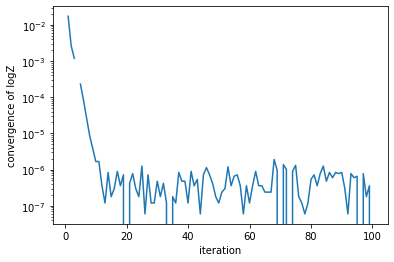

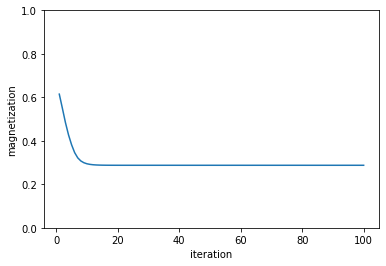

In [10]:
plt.plot(data[0],np.abs(data[1]-data[1,-1]))
plt.xlabel('iteration')
plt.ylabel('convergence of logZ')
plt.yscale('log')
plt.show()

plt.plot(data[0],np.abs(data[2]))
plt.xlabel('iteration')
plt.ylabel('magnetization')
plt.ylim([0,1])
plt.show()

# convergence of 3dising beta=0.22

In [ ]:
#beta_critical=0.2216544
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':10,
    'nLayers':30,
    'use_checkpoint':True
}

beta=0.22
params={'beta':beta,'h':0}
srg=Ising3D(params,options)
print(options)
print(params)
data=[]
for i in range(100):
    srg.optimize(1)
    num_iter=i+1
    m=srg.get_magnetization()
    print('iter',num_iter)
    print('logZ',srg.)
    printDiff('magnetization',m,ising3d.magnetization(beta))
    data.append([num_iter,srg.,m])
data=np.array(data).T

{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 10, 'nLayers': 30, 'use_checkpoint': True}
{'beta': 0.22, 'h': 0}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


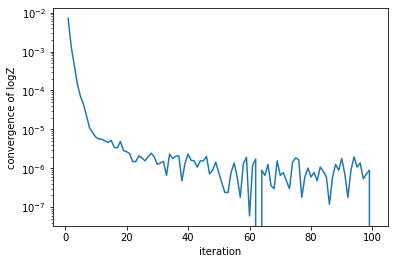

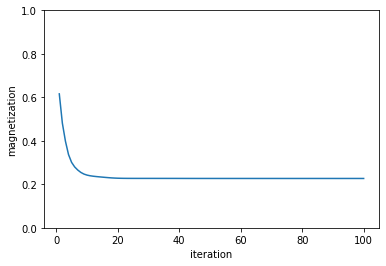

In [21]:
plt.plot(data[0],np.abs(data[1]-data[1,-1]))
plt.xlabel('iteration')
plt.ylabel('convergence of logZ')
plt.yscale('log')
plt.show()

plt.plot(data[0],np.abs(data[2]))
plt.xlabel('iteration')
plt.ylabel('magnetization')
plt.ylim([0,1])
plt.show()

In [2]:
6.6753597891*0.22

1.4685791536019999

In [3]:
assert False
#TODO
class Ising2DXTRG(SRG):
    def __init__(self,params,options):
        super(Ising2DXTRG,self).__init__(params,options)
        self.create_params_XTRG(start_dim=2,spacial_dim=2)
        self.TRG=self.XTRG2D
        
    def get_T0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,a->ijkl',W,W,W,W,sz)#UDLR
    
    def get_SZT0(self):
        beta,h=self.params['beta'],self.params['h']
        a=torch.sqrt(torch.cosh(beta))
        b=torch.sqrt(torch.sinh(beta))
        W=torch.stack([torch.stack([a,b]),torch.stack([a,-b])])
        sz=torch.stack([torch.exp(beta*h),-torch.exp(-beta*h)])
        return contract('ai,aj,ak,al,a->ijkl',W,W,W,W,sz)#UDLR
    
    def get_magnetization(self):
        with torch.no_grad():
            return _toN(torch.abs(self.forward_with_observable(self.get_SZT0())))